In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

2024-12-19 17:20:06.795934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734608106.805944   67779 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734608106.808850   67779 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow ver. 2.18.0


In [2]:
IMAGE_SIZE = 128
num_classes = 3
batch_size = 4
LR = 1e-4
EPOCHS = 50

image_path = "dataset/images/"
mask_path = "dataset/masks/"

def load_data():

    TRAIN_X = sorted(glob(os.path.join(image_path, "*.png")))
    train_x = TRAIN_X[0:90]
    TRAIN_Y = sorted(glob(os.path.join(mask_path, "*.png")))
    train_y = TRAIN_Y[0:90]
    
    valid_x = TRAIN_X[90:95]
    valid_y = TRAIN_Y[90:95]
    
    test_x = TRAIN_X[95:]
    test_y = TRAIN_Y[95:]
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data() 

In [3]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = x.astype(np.float16)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    output = []
    for i in range(num_classes):
        cmap = np.all(np.equal(x,i),axis=-1)
        # cv2.imwrite(f"cmap{i+1}.png",cmap*255)
        output.append(cmap)
    output = np.stack(output,axis=-1)
    output = output.astype(np.uint8)
    return output
 
 # Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float16, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, num_classes])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(train_x, train_y,batch=batch_size)
valid_dataset = tf_dataset_valid(valid_x, valid_y,batch=batch_size)
test_dataset = tf_dataset_valid(test_x, test_y,batch=batch_size)

I0000 00:00:1734608108.173972   67779 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
print(f" type: {type(train_dataset)},\n , train length: {len(train_x)}, val length: {len(valid_x)}, test length: {len(test_x)}")

 type: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>,
 , train length: 90, val length: 5, test length: 4


Unique pixel values in mask: [0 1 2]
Unique pixel values in mask: [0 1 2]
Unique pixel values in mask: [0 1 2]
Unique pixel values in mask: [0 1 2]


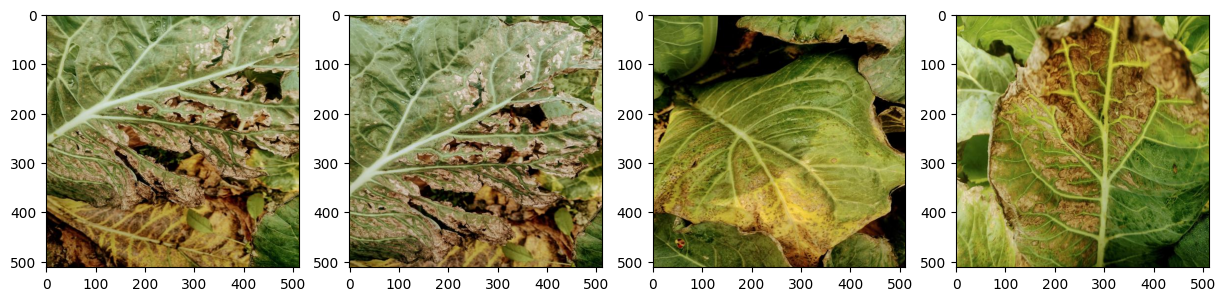

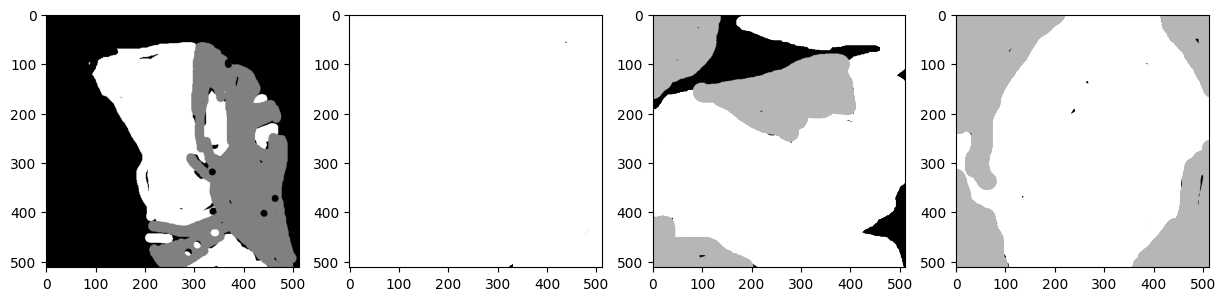

In [5]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

def read_gray_scale(y):
    y = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
    print("Unique pixel values in mask:", np.unique(y))
    return y

# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_gray_scale(train_y[0]),cmap='gray')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_gray_scale(train_y[1]),cmap='gray')
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_gray_scale(train_y[2]),cmap='gray')
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_gray_scale(train_y[3]),cmap='gray')
imgplot.set_clim(0.0, 1.4)

In [6]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [7]:
model = unet(input_shape=(128,128,3) ,num_classes=3)
opt = tf.keras.optimizers.Adam(LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,427 (118.47 MB)

 Trainable params: 31,043,651 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [8]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,   
    patience=3, 
    min_lr=0.00001,
    verbose=1
)

# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = 'weights/middle.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [9]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/50


2024-12-19 17:20:09.407871: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1734608114.185273   67871 service.cc:148] XLA service 0x7f34c8003340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734608114.185289   67871 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1734608114.939991   67871 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/23 ━━━━━━━━━━━━━━━━━━━━ 6:50 19s/step - accuracy: 0.2738 - loss: 1.4175

I0000 00:00:1734608127.899326   67871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.4205 - loss: 1.1856
Epoch 1: val_accuracy improved from -inf to 0.52480, saving model to weights/middle.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 785ms/step - accuracy: 0.4227 - loss: 1.1825 - val_accuracy: 0.5248 - val_loss: 1.0622 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6016 - loss: 0.9076
Epoch 2: val_accuracy did not improve from 0.52480
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6011 - loss: 0.9087 - val_accuracy: 0.5013 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6089 - loss: 0.8955
Epoch 3: val_accuracy improved from 0.52480 to 0.61152, saving model to weights/middle.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.6098 - loss: 0.8939 - val_accuracy: 0.6115 - val_loss: 0.9839 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6280 - loss: 0.85

(4, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
(128, 128, 3)


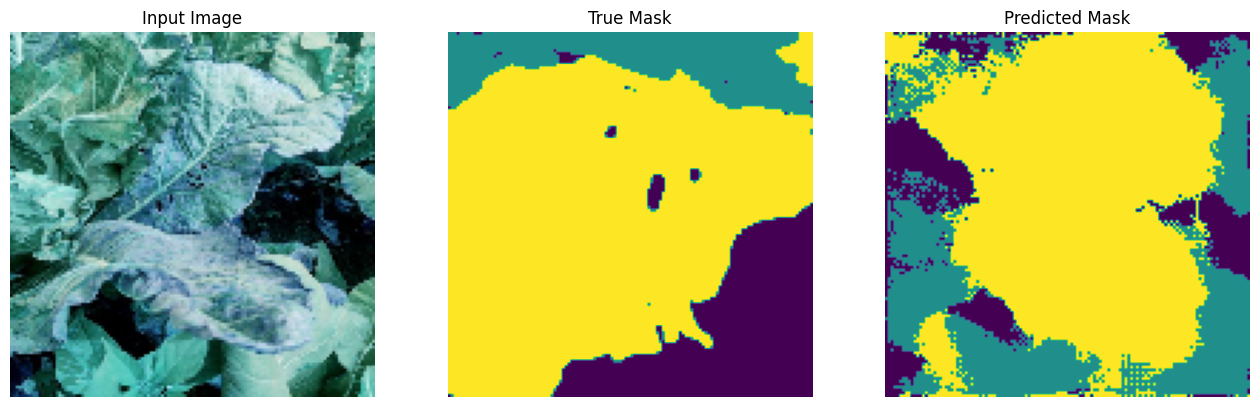

In [10]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    print(sample_mask.shape)
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    print(sample_mask[0].shape)
    original_mask = tf.argmax(sample_mask[0], axis=-1)
    original_mask = tf.expand_dims(original_mask,axis=-1)
    display_sample([sample_image[0], original_mask, pred_mask[0]])
    
for image, mask in test_dataset.take(4):
    sample_image, sample_mask = image, mask

show_predictions()